# Gaussian Process using Tanimoto kernel

In [1]:
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from GPz.model import GPR
from GPz.kern import RBF, Tanimoto, MinMaxTanimoto, Pharmacore, CombinationKern
from sklearn import cross_validation
from scipy.stats import norm
from IPython.core.display import display
from IPython.core.pylabtools import figsize

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9  
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

# Load and adjust data

In [2]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

# Removed heavy molecules
df_std1 = df_std1[df_std1['EXACT_MASS'] <= 280]
df_std2 = df_std2[df_std2['EXACT_MASS'] <= 280]

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

df_merged = pd.concat([df_std1, df_std2])
df_merged.reset_index(inplace=True)

max_intensity = df_merged['Dil_1_1'].max()
df_merged['RRF'] = df_merged['Dil_1_1'] / max_intensity
df_merged['RRF_org'] = df_merged['RRF']
df_merged['RRF'] = np.log(df_merged['RRF'])
df_merged['mol'] = df_merged['InChI'].apply(lambda x: Chem.MolFromInchi(x))

features = [
    u'JCHEM_ACIDIC_PKA',
    u'JCHEM_LOGP',
    u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA',
]

In [3]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_merged, df_merged[['RRF']], test_size=0.25, random_state=3)

In [4]:
def execute_gp(X_train, y_train, X_test, ls=1, var=1, n_var=1, k_alpha=1):    
    kern_a = RBF(ls, var, labels=features)
    kern_b = MinMaxTanimoto(X_train, X_test, label='mol', alpha=0.85, temp_dir='../data/')
    kernel = CombinationKern(kern_a, kern_b, alpha=k_alpha, func=np.add)
    gpr = GPR(X_train, y_train, kernel=kernel)
    gpr.noise_variance = n_var
    
    mu, var = gpr.predict(X_test)
    s = np.sqrt(var)
    
    return mu, s

def plot_results(y_test, mu, s, title):
    r2 = r2_score(y_test, mu)
    
    plt.xlabel('Measured (log)')
    plt.ylabel('Predicted (log)')
    plt.scatter(y_test, mu)
    
    ylim = plt.ylim()
    plt.errorbar(y_test, mu, yerr=s, fmt='o', elinewidth=1, capthick=1, capsize=3, lolims=False, uplims=False)
    # plt.ylim(*ylim)
    
    xlim = plt.xlim()
    plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
    plt.xlim(*xlim)
    
    plt.grid(True)
    plt.title(title + ' $R^2$={:.3f}'.format(r2))

# Cross Validation

In [5]:
def cv(ls, var, nvar):
    k_fold = cross_validation.KFold(len(X_train), n_folds=5)

    grid_results = []
    alphas = np.linspace(0.0001, 1.0, num=100)

    for i, (train_fold, test_fold) in enumerate(k_fold):
        X_train_fold = X_train.iloc[train_fold]
        y_train_fold = X_train.iloc[train_fold]['RRF']
        X_test_fold = X_train.iloc[test_fold]
        y_test_fold = X_train.iloc[test_fold]['RRF']

        for p_a in alphas:
            mu, s = execute_gp(X_train_fold, y_train_fold, X_test_fold, ls, var, nvar, p_a)
            log_likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(y_test_fold, mu, s)])
            grid_results.append((p_a, log_likelihood))
    
    # Find the best parameter
    df = DataFrame(grid_results, columns=['Alpha', 'LogLikelihood'])
    best = df.groupby(['Alpha']).agg({'LogLikelihood' : np.sum}).sort(['LogLikelihood'], ascending=False)
    display(best.head(10))
    
    return df, best.iloc[0].name

In [6]:
p_ls = 179.591837
p_var = 46326530.612245
p_n_var = 4.333
df, alpha = cv(179.591837, 46326530.612245, 4.333)

,LogLikelihood
Alpha,
0.9394,-147.776162
0.9293,-147.788844
0.9495,-147.820737
0.9192,-147.844017
0.9091,-147.931391
0.9596,-147.944867
0.8990,-148.043516
0.8889,-148.174842
0.9697,-148.184669


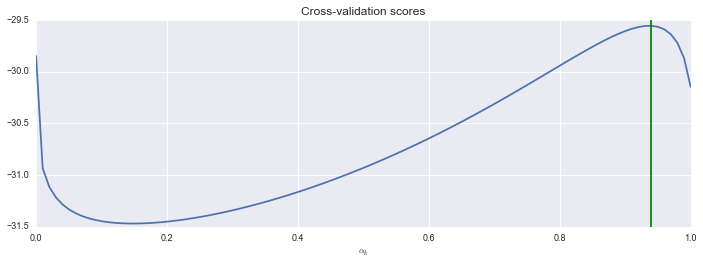

In [7]:
perf = df.groupby(['Alpha']).agg({'LogLikelihood' : np.mean})

figsize(1.2 * default_fig_w, 0.7 * default_fig_h)
plt.plot(perf.index, perf['LogLikelihood'])
plt.axvline(perf[perf['LogLikelihood'] == perf['LogLikelihood'].max()].iloc[0].name, color='g')

plt.title('Cross-validation scores')
plt.xlabel('$\\alpha_{k}$')
plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/gu_combined_rbf_minmax_alpha.pdf')
    
plt.show()

Test Log-likelihood: -53.540


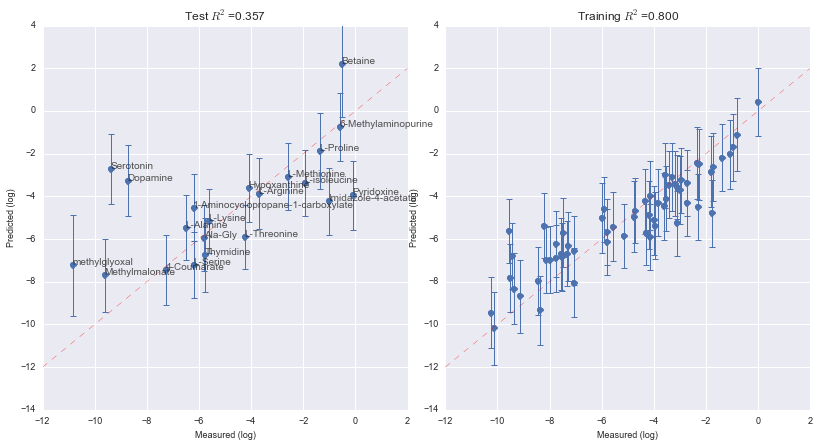

In [8]:
mu, var = execute_gp(X_train, X_train['RRF'], X_test, ls=p_ls, var=p_var, n_var=p_n_var, k_alpha=alpha)
s = np.sqrt(var)

likelihoods = [norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(y_test['RRF'], mu, s)]
print("Test Log-likelihood: {:.3f}".format(np.sum(likelihoods)))

figsize(1.4 * default_fig_w, 1.2 * default_fig_h)

ax = plt.subplot(1, 2, 1)
plot_results(y_test['RRF'], mu, s, title='Test')    
for x, y, label in zip(y_test['RRF'], mu, X_test['Name']):
    ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)


train_mu, train_var = execute_gp(X_train, X_train['RRF'], X_train, 
                     ls=p_ls, 
                     var=p_var, 
                     n_var=p_n_var, 
                     k_alpha=alpha)
train_s = np.sqrt(train_var)
plt.ylim([-14, 4])

plt.subplot(1, 2, 2)
plot_results(y_train['RRF'], train_mu, train_s, title='Training')
plt.ylim([-14, 4])

plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/gu_combined_rbf_minmax.pdf')

plt.show()